## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Data preparation

### Load and combine datasets

In [ ]:
monday = pd.read_csv('Monday-WorkingHours.pcap_lycos.csv')
tuesday = pd.read_csv('Tuesday-WorkingHours.pcap_lycos.csv')
wednesday = pd.read_csv('Wednesday-WorkingHours.pcap_lycos.csv')
thursday = pd.read_csv('Thursday-WorkingHours.pcap_lycos.csv')
friday = pd.read_csv('Friday-WorkingHours.pcap_lycos.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Drop flow characterization features and URG flags because they have only zero values
drop_list = ['flag_urg', 'fwd_flag_urg', 'bwd_flag_urg',
             'flow_id', 'timestamp','src_addr', 'src_port',
             'dst_addr', 'ip_prot', "dst_port"]

In [ ]:
dataset = pd.concat([monday, tuesday, wednesday, thursday, friday])
dataset = dataset.drop(columns=drop_list)
dataset.head()

,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,...,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes,label
0,84524,0.000000,8.0,8.0,8.00,0.000000,0.000000,3.785907e+02,47.323837,0.000000,...,32.000000,4.000000,378.590696,0.0,0.0,32.0,4.0,-1,-1,benign
1,98644,0.000000,28.0,28.0,28.00,0.000000,0.000000,5.109282e+03,182.474352,182.474352,...,0.000000,0.000000,0.000000,504.0,18.0,0.0,0.0,-1,-1,benign
2,83068408,1.105263,68.0,50.0,59.15,43.724051,6.612416,5.696510e+01,0.963062,0.457454,...,281.333333,4.666667,14842.170052,222.4,3.8,250.8,4.2,-1,-1,benign
3,292,1.000000,131.0,81.0,106.00,833.333333,28.867513,1.452055e+06,13698.630137,6849.315068,...,0.000000,0.000000,0.000000,162.0,2.0,262.0,2.0,-1,-1,benign
4,293,1.000000,131.0,81.0,106.00,833.333333,28.867513,1.447099e+06,13651.877133,6825.938567,...,0.000000,0.000000,0.000000,162.0,2.0,262.0,2.0,-1,-1,benign


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1837498 entries, 0 to 542961
Data columns (total 73 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   flow_duration           int64  
 1   down_up_ratio           float64
 2   pkt_len_max             float64
 3   pkt_len_min             float64
 4   pkt_len_mean            float64
 5   pkt_len_var             float64
 6   pkt_len_std             float64
 7   bytes_per_s             float64
 8   pkt_per_s               float64
 9   fwd_pkt_per_s           float64
 10  bwd_pkt_per_s           float64
 11  fwd_pkt_cnt             int64  
 12  fwd_pkt_len_tot         int64  
 13  fwd_pkt_len_max         float64
 14  fwd_pkt_len_min         float64
 15  fwd_pkt_len_mean        float64
 16  fwd_pkt_len_std         float64
 17  fwd_pkt_hdr_len_tot     int64  
 18  fwd_pkt_hdr_len_min     int64  
 19  fwd_non_empty_pkt_cnt   int64  
 20  bwd_pkt_cnt             int64  
 21  bwd_pkt_len_tot         int64  


In [ ]:
dataset.describe()

,flow_duration,down_up_ratio,pkt_len_max,pkt_len_min,pkt_len_mean,pkt_len_var,pkt_len_std,bytes_per_s,pkt_per_s,fwd_pkt_per_s,...,fwd_bulk_rate_mean,bwd_bulk_bytes_mean,bwd_bulk_pkt_mean,bwd_bulk_rate_mean,fwd_subflow_bytes_mean,fwd_subflow_pkt_mean,bwd_subflow_bytes_mean,bwd_subflow_pkt_mean,fwd_tcp_init_win_bytes,bwd_tcp_init_win_bytes
count,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,...,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06,1.837498e+06
mean,1.199375e+07,1.051375e+00,1.388679e+03,2.117446e+01,3.051886e+02,9.484971e+05,4.775796e+02,5.902847e+05,1.233599e+04,7.515683e+03,...,1.821951e+05,4.215857e+03,2.093305e+00,2.855677e+06,2.681484e+02,6.813951e+00,1.395996e+04,8.270970e+00,1.069511e+04,1.146236e+04
std,3.091508e+07,4.082071e-01,2.375817e+03,2.643862e+01,4.622562e+02,2.627050e+06,8.487727e+02,8.554230e+06,6.437455e+04,5.069289e+04,...,4.130112e+06,3.184214e+05,1.130538e+02,1.033698e+07,2.453107e+03,7.225960e+02,2.151137e+06,9.674378e+02,1.568257e+04,1.554986e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.240000e+02,1.000000e+00,6.800000e+01,0.000000e+00,5.300000e+01,3.413333e+02,1.847521e+01,2.178995e+02,6.623747e+00,2.804731e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.800000e+01,1.000000e+00,9.800000e+01,1.000000e+00,-1.000000e+00,-1.000000e+00
50%,6.205000e+04,1.000000e+00,1.380000e+02,0.000000e+00,8.450000e+01,3.267000e+03,5.715768e+01,5.623089e+03,6.527202e+01,3.249708e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.400000e+01,2.000000e+00,2.060000e+02,2.000000e+00,3.640000e+02,0.000000e+00
75%,1.459716e+06,1.000000e+00,1.460000e+03,4.100000e+01,2.748000e+02,2.719068e+05,5.214468e+02,8.166786e+04,1.238390e+04,6.116208e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.020000e+02,3.000000e+00,1.762500e+03,3.500000e+00,2.920000e+04,2.896000e+04
max,1.200000e+08,8.070423e+00,2.482000e+04,1.448000e+03,2.391375e+03,2.686570e+07,5.183213e+03,1.983000e+09,2.000000e+06,2.000000e+06,...,9.740000e+08,1.567619e+08,5.827075e+04,1.369000e+09,1.783979e+06,2.197590e+05,6.554523e+08,2.919220e+05,6.553500e+04,6.553500e+04


In [ ]:
dataset['label'].value_counts(normalize=True) * 100

benign                     75.955185
portscan                    8.713261
dos_hulk                    8.652418
ddos                        5.207244
dos_goldeneye               0.368164
dos_slowloris               0.308789
dos_slowhttptest            0.264817
ftp_patator                 0.217851
ssh_patator                 0.161034
webattack_bruteforce        0.074014
bot                         0.040000
webattack_xss               0.035973
webattack_sql_injection     0.000653
heartbleed                  0.000599
Name: label, dtype: float64

In [ ]:
dataset['label'].value_counts()

benign                     1395675
portscan                    160106
dos_hulk                    158988
ddos                         95683
dos_goldeneye                 6765
dos_slowloris                 5674
dos_slowhttptest              4866
ftp_patator                   4003
ssh_patator                   2959
webattack_bruteforce          1360
bot                            735
webattack_xss                  661
webattack_sql_injection         12
heartbleed                      11
Name: label, dtype: int64

In [ ]:
len(dataset['label'].unique())

14

In [ ]:
c = dataset['label'].unique()

## Rebalance Dataset

Undersamples dataset to keep 25% of benign traffic and rest of  50%

In [ ]:
df_majority = dataset[dataset['label'] == 'benign']
df_minority = dataset[dataset['label'] != 'benign']

In [ ]:
n_majority_keep = int(df_majority.shape[0] * 0.5)
n_minority_keep = int(df_minority.shape[0] * 0.5)

In [ ]:
n_majority_keep, n_minority_keep

(697837, 220911)

In [ ]:
df_majority_under = resample(
    df_majority,
    replace=False,
    n_samples=n_majority_keep
)


df_minority_under = resample(
    df_minority,
    replace=False,
    n_samples=n_minority_keep
)

In [ ]:
df_balanced = pd.concat([df_majority_under, df_minority_under])

In [ ]:
df_balanced.shape[0]

918748

In [ ]:
df_balanced['label'].value_counts(normalize=True) * 100

benign                     75.955213
portscan                    8.686930
dos_hulk                    8.653515
ddos                        5.232556
dos_goldeneye               0.367239
dos_slowloris               0.306939
dos_slowhttptest            0.264599
ftp_patator                 0.214531
ssh_patator                 0.164245
webattack_bruteforce        0.074885
bot                         0.040599
webattack_xss               0.037333
webattack_sql_injection     0.000762
heartbleed                  0.000653
Name: label, dtype: float64

In [ ]:
df_balanced['label'].value_counts()

benign                     697837
portscan                    79811
dos_hulk                    79504
ddos                        48074
dos_goldeneye                3374
dos_slowloris                2820
dos_slowhttptest             2431
ftp_patator                  1971
ssh_patator                  1509
webattack_bruteforce          688
bot                           373
webattack_xss                 343
webattack_sql_injection         7
heartbleed                      6
Name: label, dtype: int64

In [ ]:
df_balanced[df_balanced['label'] != 'benign'].shape[0]

220911

### Create Train Test splits

In [ ]:
CLASSES = np.sort(df_balanced["label"].unique())
CLASSES

array(['benign', 'bot', 'ddos', 'dos_goldeneye', 'dos_hulk',
       'dos_slowhttptest', 'dos_slowloris', 'ftp_patator', 'heartbleed',
       'portscan', 'ssh_patator', 'webattack_bruteforce',
       'webattack_sql_injection', 'webattack_xss'], dtype=object)

In [ ]:
CLASSES.shape

(14,)

In [ ]:
X, y = df_balanced.drop(columns='label'), df_balanced["label"]

### Encode target variable

In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [ ]:
np.unique(y_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

### Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.25,
    random_state=17,
    stratify=y_encoded
)

In [ ]:
def format_counts(y_train, y_test):
    train_class, train_counts = np.unique(y_train, return_counts=True)
    test_class, test_counts = np.unique(y_test, return_counts=True)
    train = pd.DataFrame({"Traffic": encoder.classes_[train_class], "Label": train_class, "Tain set": train_counts})
    test = pd.DataFrame({"Traffic": encoder.classes_[train_class], "Label": train_class, "Test set": test_counts})
    return train.merge(test)

In [ ]:
y_train.shape, y_test.shape

((689061,), (229687,))

In [ ]:
format_counts(y_train, y_test)

,Traffic,Label,Tain set,Test set
0,benign,0,523378,174459
1,bot,1,271,90
2,ddos,2,35744,11914
3,dos_goldeneye,3,2478,826
4,dos_hulk,4,59713,19904
5,dos_slowhttptest,5,1785,595
6,dos_slowloris,6,2162,721
7,ftp_patator,7,1498,499
8,heartbleed,8,4,2
9,portscan,9,60224,20075


## PCA

In [ ]:
pipe = make_pipeline(StandardScaler(), PCA())

In [ ]:
pipe.fit(X_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

In [ ]:
X_train.shape

(689061, 72)

In [ ]:
pca_step = pipe.named_steps['pca']

In [ ]:
pca_step.components_.shape

(72, 72)

In [ ]:
pca_step.components_

array([[ 2.16700898e-01, -7.88358689e-03,  2.98544440e-02, ...,
         3.90776915e-02,  4.99856955e-02,  8.09319169e-02],
       [-1.54608123e-02,  9.02698147e-02,  1.41122121e-01, ...,
         2.31162047e-01,  8.89096203e-02,  1.10998184e-01],
       [-2.23374752e-02, -1.46963280e-01, -2.33857746e-01, ...,
         1.50474802e-01, -1.60363331e-01, -2.04196275e-01],
       ...,
       [-1.94966326e-03, -4.47605798e-04,  7.60108896e-04, ...,
         8.98285697e-04, -2.96958208e-05, -3.25727092e-05],
       [ 1.23841405e-12, -7.00131073e-14,  4.54957788e-13, ...,
        -8.38492470e-13,  9.24815780e-14,  3.70814490e-14],
       [ 0.00000000e+00, -2.75176696e-16,  6.50198602e-16, ...,
         1.13305943e-15, -7.50111467e-17,  2.32240089e-17]])

In [ ]:
pca_step.explained_variance_

array([1.27131377e+01, 1.11580587e+01, 1.05817279e+01, 4.89458544e+00,
       3.24323375e+00, 2.81503553e+00, 2.61991941e+00, 2.20144246e+00,
       1.90587256e+00, 1.67969032e+00, 1.52009730e+00, 1.43025404e+00,
       1.33154207e+00, 1.13379918e+00, 1.07357646e+00, 1.02532081e+00,
       9.91956987e-01, 9.21088482e-01, 8.50708654e-01, 8.06678441e-01,
       7.50870917e-01, 7.27036759e-01, 6.65322887e-01, 5.85239190e-01,
       4.84824090e-01, 4.71419218e-01, 4.48616348e-01, 3.63689680e-01,
       3.52062789e-01, 3.51213673e-01, 2.77903528e-01, 2.08948137e-01,
       1.84954547e-01, 1.77055951e-01, 1.45060375e-01, 1.35028721e-01,
       1.17602615e-01, 1.11995664e-01, 1.05427480e-01, 1.01316304e-01,
       7.37756324e-02, 5.25156876e-02, 4.68076057e-02, 3.66186364e-02,
       3.58775387e-02, 2.38629034e-02, 1.59344101e-02, 1.20928082e-02,
       9.84154130e-03, 5.40661753e-03, 4.87886036e-03, 4.14714841e-03,
       3.46087927e-03, 2.72803003e-03, 1.87182284e-03, 1.73968492e-03,
      

In [ ]:
pca_step.n_components_

72

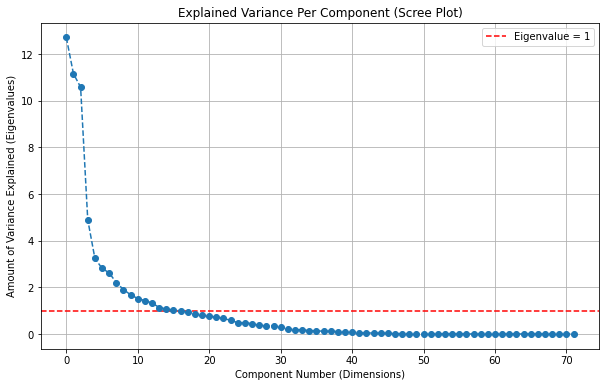

In [ ]:
plt.figure(figsize=(10,6))
plt.ylabel("Amount of Variance Explained (Eigenvalues)")
plt.xlabel("Component Number (Dimensions)")
plt.title("Explained Variance Per Component (Scree Plot)")
plt.axhline(y=1, color="r", linestyle="--", label="Eigenvalue = 1")
plt.style.context('seaborn-whitegrid')
plt.grid()
plt.plot(pca_step.explained_variance_,"--o")
plt.legend()
plt.savefig('scree_plot.png')
plt.show()


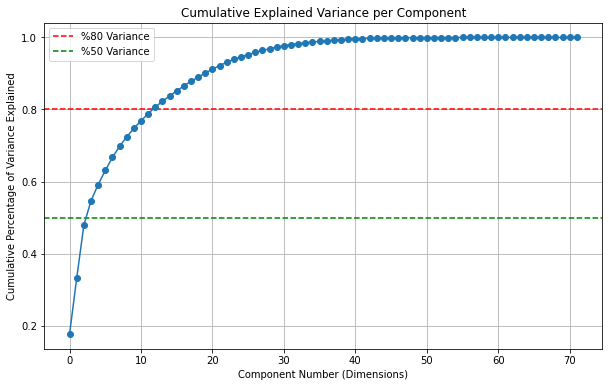

In [ ]:
plt.figure(figsize=(10,6))
plt.ylabel("Cumulative Percentage of Variance Explained")
plt.xlabel("Component Number (Dimensions)")
plt.title("Cumulative Explained Variance per Component")
plt.axhline(y=0.8, color="r", linestyle="--",label="%80 Variance")
plt.axhline(y=0.5, color="g", linestyle="--",label="%50 Variance")
plt.style.context('seaborn-whitegrid')
plt.grid()
plt.plot(np.cumsum(pca_step.explained_variance_ratio_),"-o")
plt.legend()
plt.savefig('cumulative_plot.png')
plt.show()

Variance explained by the top 3

In [ ]:
np.sum(pca_step.explained_variance_ratio_[:3])

0.4785121435403379

In [ ]:
 X_train.columns

Index(['flow_duration', 'down_up_ratio', 'pkt_len_max', 'pkt_len_min',
       'pkt_len_mean', 'pkt_len_var', 'pkt_len_std', 'bytes_per_s',
       'pkt_per_s', 'fwd_pkt_per_s', 'bwd_pkt_per_s', 'fwd_pkt_cnt',
       'fwd_pkt_len_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_min',
       'fwd_pkt_len_mean', 'fwd_pkt_len_std', 'fwd_pkt_hdr_len_tot',
       'fwd_pkt_hdr_len_min', 'fwd_non_empty_pkt_cnt', 'bwd_pkt_cnt',
       'bwd_pkt_len_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_min',
       'bwd_pkt_len_mean', 'bwd_pkt_len_std', 'bwd_pkt_hdr_len_tot',
       'bwd_pkt_hdr_len_min', 'bwd_non_empty_pkt_cnt', 'iat_max', 'iat_min',
       'iat_mean', 'iat_std', 'fwd_iat_tot', 'fwd_iat_max', 'fwd_iat_min',
       'fwd_iat_mean', 'fwd_iat_std', 'bwd_iat_tot', 'bwd_iat_max',
       'bwd_iat_min', 'bwd_iat_mean', 'bwd_iat_std', 'active_max',
       'active_min', 'active_mean', 'active_std', 'idle_max', 'idle_min',
       'idle_mean', 'idle_std', 'flag_SYN', 'flag_fin', 'flag_rst', 'flag_ack',
       'flag_ps

#### Heatmap with the loadings of the top 3 components

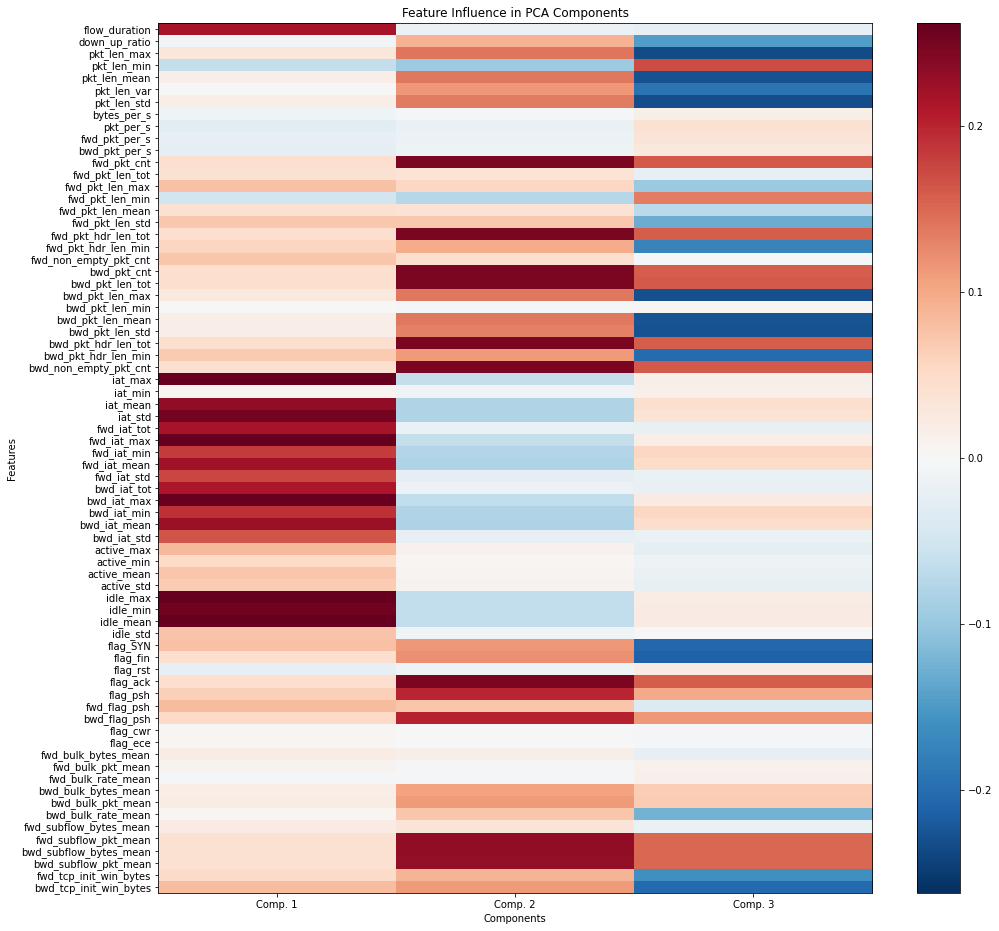

In [ ]:
components = pca_step.components_[:3].T
vmax = np.abs(components).max()
plt.figure(figsize=(16,16))
plt.imshow(components, cmap="RdBu_r", vmax=vmax, vmin=-vmax, aspect='auto')
plt.title("Feature Influence in PCA Components")
plt.yticks(np.arange(len(X_train.columns)), X_train.columns)
plt.xticks([0,1,2], ["Comp. 1", "Comp. 2", "Comp. 3"])
plt.xlabel("Components")
plt.ylabel("Features")
plt.colorbar()
plt.savefig('heatmap.png')
plt.show()

### Test Different Training Times by Dimension

The goal is to measure the latency one can expect when doing predictions. Since the dataset is big, we'll use a 10% sample random sample to speed up calculations

'micro' = Calculate metrics globally by counting the total true positives, false negatives and false positives.

False Positive Rate (FPR) is the percentage of benign traffic classified as attacks.

In [ ]:
int(X_train.shape[0] * 0.5)

344530

In [ ]:
X_sample, y_sample = resample(
    X_train,
    y_train,
    n_samples=int(X_train.shape[0] * 0.1),
    replace=False,
    random_state=42,
    stratify=y_train
)

In [ ]:
def get_fpr(y, pred):
    mat = multilabel_confusion_matrix(y, pred)[0]
    tn, fp, fn, tp = mat.ravel()
    false_positive_rate = fp /(tn + fp)
    return false_positive_rate

In [ ]:
def measure_components(X, y):
    components = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    stats = {
        'variance_explained':[],
        'training_inference':[],
        'Accuracy': [],
        'Precision':[],
        'Recall':[],
        'F1': [],
        'FPR': []
    }
    for pct in components:
        pipe = make_pipeline(
            StandardScaler(),
            PCA(n_components=pct),
            DecisionTreeClassifier(max_depth=10, n_c),
        )
        start = time.time()
        preds = cross_val_predict(pipe, X, y, cv=5)
        stats['training_inference'].append(time.time() - start)
        stats['variance_explained'].append(pct)
        stats['Accuracy'].append(accuracy_score(y, preds))
        stats['Precision'].append(precision_score(y, preds, average='weighted'))
        stats['Recall'].append(recall_score(y, preds, average='weighted'))
        stats['F1'].append(f1_score(y, preds, average='weighted'))
        stats['FPR'].append(get_fpr(y, preds))
    return pd.DataFrame(stats)


In [ ]:
measure_components(X_train, y_train)

C:\Users\lesth\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lesth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lesth\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\lesth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users

,variance_explained,training_inference,Accuracy,Precision,Recall,F1,FPR
0,0.50,25.895793,0.993435,0.992547,0.993435,0.992651,0.019640
1,0.60,52.593488,0.993231,0.992650,0.993231,0.992656,0.021565
2,0.70,83.943220,0.995021,0.994926,0.995021,0.994666,0.014015
3,0.80,110.109255,0.994752,0.994309,0.994752,0.994358,0.016459
4,0.90,144.431382,0.995402,0.995198,0.995402,0.995085,0.013019
5,0.95,130.317849,0.995051,0.994769,0.995051,0.994653,0.014262
6,0.99,176.813863,0.994796,0.994397,0.994796,0.994347,0.016731


In [ ]:
def get_n_components(X_train):
    components = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    df = pd.DataFrame(columns=["pct", "n"])
    for pct in components:
        comp = make_pipeline(StandardScaler(), PCA(n_components=pct))
        comp.fit(X_train)
        pca_n = comp.named_steps['pca'].n_components_
        row = pd.DataFrame({'pct':pct, 'n':pca_n}, index=[0])
        df = pd.concat([df, row], ignore_index=True)
    return df

In [ ]:
get_n_components(X_train)

,pct,n
0,0.5,4
1,0.6,6
2,0.7,8
3,0.8,13
4,0.9,20
5,0.95,26
6,0.99,37


## Performance Comparison

Compare performance of different algorithms using components that caputre 80% of variance from the dataset. So, after running the preprocessing pipeline, the training and test datasets will have 13 features

In [ ]:
comp = make_pipeline(StandardScaler(), PCA(n_components=0.8))
comp.fit(X_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.8))])

In [ ]:
comp.named_steps['pca'].n_components_

13

In [ ]:
def get_fpr(y, pred):
    mat = multilabel_confusion_matrix(y, pred)[0]
    tn, fp, fn, tp = mat.ravel()
    false_positive_rate = fp /(tn + fp)
    return false_positive_rate

In [ ]:
def create_row(model_name, y, predictions):
    data = {
        'algorithm': model_name,
        'accuracy': accuracy_score(y, predictions),
        'precision': precision_score(y, predictions, average='weighted'),
        'recall': recall_score(y, predictions, average='weighted'),
        'f1': f1_score(y, predictions, average='weighted'),
        'fpr': get_fpr(y, predictions)
    }
    row = pd.DataFrame(data, index=[0])
    return row

In [ ]:
def create_pipe(estimator):
    pipe = make_pipeline(
            StandardScaler(),
            PCA(n_components=0.8),
            estimator
        )
    return pipe

In [ ]:
def compute_table(models, X_train, y_train, X_test, y_test):
    columns = ['algorithm', 'accuracy', 'precision', 'recall', 'f1', 'fpr','training_time', 'infer_time']
    df = pd.DataFrame(columns=columns)
    for name, estimator in models.items():
        pipe = create_pipe(estimator)
        train_start = time.time()
        pipe.fit(X_train, y_train)
        train_end = time.time() - train_start
        infer_start = time.time()
        preds = pipe.predict(X_test)
        infer_end = time.time() - infer_start
        row = create_row(name, y_test, preds)
        row['training_time'] = train_end
        row['infer_time'] = infer_end
        df = pd.concat([df, row], ignore_index=True)
    return df

In [ ]:
models = {
    'LDA':LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM': LinearSVC(tol=0.01, max_iter=200),
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'DT': DecisionTreeClassifier(max_depth=10),
    'RF':  RandomForestClassifier(n_estimators=10, max_depth=10, random_state=0)
}

In [ ]:
results = compute_table(models, X_train, y_train, X_test, y_test)
results

C:\Users\lesth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lesth\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\lesth\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lesth\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\lesth\anaconda3\lib\site-packages\sklearn\metrics\_cla

,algorithm,accuracy,precision,recall,f1,fpr,training_time,infer_time
0,LDA,0.921493,0.937065,0.921493,0.927602,0.036395,4.193656,0.2601
1,QDA,0.97686,0.991342,0.97686,0.982633,0.006772,3.485303,0.686366
2,SVM,0.983565,0.978395,0.983565,0.979941,0.037173,329.67689,0.22617
3,k-NN,0.998424,0.998454,0.998424,0.998414,0.001105,5.085111,10.812561
4,DT,0.995098,0.994731,0.995098,0.994651,0.015662,12.834591,0.208812
5,RF,0.995341,0.994869,0.995341,0.994655,0.01626,20.141706,0.462643


In [ ]:
X_test.shape

(229687, 72)

In [ ]:
print(results)

  algorithm  accuracy precision    recall        f1       fpr training_time  \
0       LDA  0.921493  0.937065  0.921493  0.927602  0.036395      4.193656   
1       QDA   0.97686  0.991342   0.97686  0.982633  0.006772      3.485303   
2       SVM  0.983565  0.978395  0.983565  0.979941  0.037173     329.67689   
3      k-NN  0.998424  0.998454  0.998424  0.998414  0.001105      5.085111   
4        DT  0.995098  0.994731  0.995098  0.994651  0.015662     12.834591   
5        RF  0.995341  0.994869  0.995341  0.994655   0.01626     20.141706   

  infer_time  
0     0.2601  
1   0.686366  
2    0.22617  
3  10.812561  
4   0.208812  
5   0.462643  
